In [2]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
pl.Config.set_tbl_rows(100)
pl.Config.set_thousands_separator(",")


polars.config.Config

In [64]:
df = pl.read_parquet('../03_transform/car_ads_transformed.parquet')

In [65]:
df.shape

(185233, 19)

In [66]:
df.select(df.columns[:-5]).head(3)

price,brand,model,is_automatic,km,fuel,year,age_years,is_seller_pro,is_certified,offer_type,location,ad_days_creation,ad_days_published
i32,str,str,bool,i32,str,i32,i32,bool,bool,str,str,i32,i32
"12,990","""mini""","""mini""",true,"165,399","""diesel""","2,015",9,true,false,"""ocasion""","""madrid""",0,0
"10,500","""audi""","""a1""",false,"143,139","""diesel""","2,013",11,true,false,"""ocasion""","""madrid""",0,0
"11,450","""fiat""","""500""",false,"81,696","""gasolina""","2,018",6,true,false,"""ocasion""","""madrid""",0,0


## Price distribution analysis

In [67]:
quantiles = list(np.arange(0.00, 1.05, 0.05).round(2))
quantiles.insert(1, 0.03)
quantiles.insert(-1, 0.97)
quantiles.insert(-1, 0.98)
quantiles.insert(-1, 0.99)

In [7]:
# Create a dictionary to store the quantile expressions for each quantile
quantile_exprs = [pl.col('price').quantile(q).alias(f'quantile_{q:.2f}') for q in quantiles]

# Use the select method with the list of quantile expressions
df_quantiles = df.select(quantile_exprs)

In [8]:
df_quantiles

quantile_0.00,quantile_0.03,quantile_0.05,quantile_0.10,quantile_0.15,quantile_0.20,quantile_0.25,quantile_0.30,quantile_0.35,quantile_0.40,quantile_0.45,quantile_0.50,quantile_0.55,quantile_0.60,quantile_0.65,quantile_0.70,quantile_0.75,quantile_0.80,quantile_0.85,quantile_0.90,quantile_0.95,quantile_0.97,quantile_0.98,quantile_0.99,quantile_1.00
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
300.0,"1,700.0","2,200.0","3,499.0","4,500.0","6,000.0","7,500.0","8,999.0","10,595.0","12,000.0","13,699.0","14,999.0","16,500.0","17,990.0","19,600.0","21,490.0","23,500.0","25,990.0","29,490.0","34,900.0","44,800.0","52,000.0","60,500.0","79,000.0",1.2341243e7


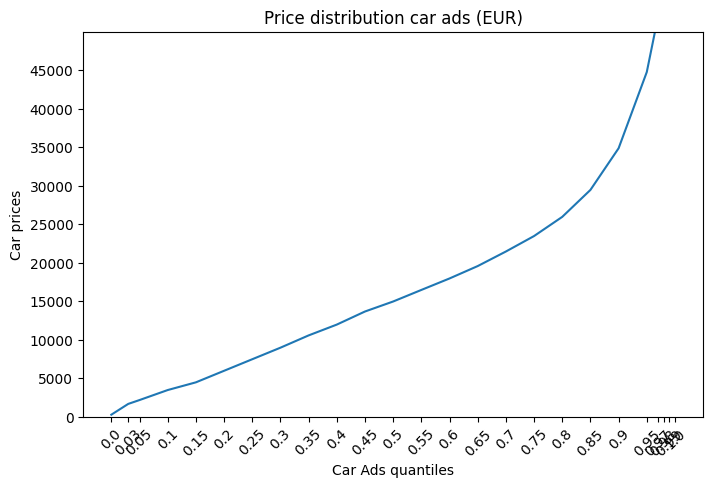

In [9]:
plt.figure(figsize=(8,5))
sns.lineplot(x=quantiles, y=df_quantiles.row(0))
plt.title('Price distribution car ads (EUR)')
plt.xlabel('Car Ads quantiles')
plt.ylabel('Car prices')
plt.ylim(0,50_000)
plt.xticks(ticks=quantiles, labels=quantiles, rotation=45)
plt.yticks(np.arange(0,50_000, 5_000));

In [10]:
# We'll cap (filter) the cars with price values over 120K EUR as 99% of the cars have lower prices
# I believe the model prediction will generalize better in this way
# Eventually we could create a model predictor for expensive cars

expensive_models_df = (
    df
    .group_by('brand','model')
    .agg(pl.col('price').max().alias('max_price'))
    .sort(['max_price'], descending=True)
    .with_row_index(name='rank',offset=1)
    .head(100)
)

In [11]:
expensive_models_df.tail(15)

rank,brand,model,max_price
u32,str,str,i32
86,"""aston martin""","""rapide""","125,000"
87,"""mercedes-benz""","""clase gle coupe""","124,990"
88,"""volkswagen""","""golf""","123,006"
89,"""maserati""","""grecale""","122,900"
90,"""mercedes-benz""","""clase cl""","120,000"
91,"""mercedes-benz""","""190""","119,900"
92,"""mercedes-benz""","""gle""","119,000"
93,"""corvette""","""corvette""","117,500"
94,"""ferrari""","""360""","116,900"


In [12]:
# We want to filter out car ads with nonsensical prices (example: a cheap model selling for 200K)
# We calculate outlier bounds with classic formula (adjusted to 3*IQR): (Q75 + 3*IQR) and (Q25 - 3*IQR)
# Note, if lower bound is negative, we replace it with 0.
df = (
    df
    .with_columns(
        (
            pl.col('price').quantile(0.25).over(['brand','model']) 
            -
            ((pl.col('price').quantile(0.75).over(['brand','model']) - pl.col('price').quantile(0.25).over(['brand','model']))
              * 3)
        ).alias('price_outlier_low'),
        (
            pl.col('price').median().over(['brand','model']).name.suffix('_median')),
        (
            pl.col('price').quantile(0.75).over(['brand','model']) 
            +
            ((pl.col('price').quantile(0.75).over(['brand','model']) - pl.col('price').quantile(0.25).over(['brand','model']))
              * 3)
        ).alias('price_outlier_up')

    )
    .with_columns(
        pl.max_horizontal(pl.lit(0),pl.col('price_outlier_low')).alias('price_outlier_low')
    )
        .with_columns(
        ((pl.col('price') - pl.col('price_median')).abs() / pl.col('price_median')).round(1).cast(pl.Float32).alias('%_deviation_price_median')
        )
)

In [13]:
df.drop(['url','bodyTypeId']).head(3)

price,brand,model,is_automatic,km,fuel,year,age_years,is_seller_pro,is_certified,offer_type,location,ad_days_creation,ad_days_published,cubic_capacity,title,body_type,price_outlier_low,price_median,price_outlier_up,%_deviation_price_median
i32,str,str,bool,i32,str,i32,i32,bool,bool,str,str,i32,i32,i32,str,str,f64,f64,f64,f32
"12,990","""mini""","""mini""",true,"165,399","""diesel""","2,015",9,true,false,"""ocasion""","""madrid""",0,0,"1,496","""mini mini cooper d automatico …","""berlina""",0.0,"13,990.0","56,050.0",0.1
"10,500","""audi""","""a1""",false,"143,139","""diesel""","2,013",11,true,false,"""ocasion""","""madrid""",0,0,"1,598","""audi a1 sportback 1.6 tdi 90cv…","""berlina""",0.0,"17,500.0","41,500.0",0.4
"11,450","""fiat""","""500""",false,"81,696","""gasolina""","2,018",6,true,false,"""ocasion""","""madrid""",0,0,"1,242","""fiat 500 1.2 8v 51kw 69cv coll…","""berlina""",0.0,"11,390.0","22,870.0",0.0


In [14]:
# There are 952 cars that we consider outliers. We can see that we can identify 'nonsensical' car ads (example: opel insignia for 490K)
(   
    (df
    .filter(
        (~pl.col('price').is_between(pl.col('price_outlier_low'), pl.col('price_outlier_up')))
        )

    )[['%_deviation_price_median','price', 'price_median', 'price_outlier_low', 'price_outlier_up', 'model', 'brand']]
    .sort(by='%_deviation_price_median', descending=True).head(15)
)

%_deviation_price_median,price,price_median,price_outlier_low,price_outlier_up,model,brand
f32,i32,f64,f64,f64,str,str
424.600006,"12,341,243","28,999.5","10,460.0","49,030.0","""u5""","""aiways"""
59.0,"180,000","3,000.0",0.0,"8,300.0","""r21""","""renault"""
53.5,"490,000","8,990.0",0.0,"35,715.0","""insignia""","""opel"""
30.700001,"111,111","3,500.0",0.0,"15,800.0","""zafira""","""opel"""
29.0,"119,900","4,000.0",0.0,"13,000.0","""190""","""mercedes-benz"""
27.1,"140,000","4,975.0",0.0,"53,000.0","""180d""","""mercedes-benz"""
19.0,"50,000","2,500.0",0.0,"12,860.0","""toledo""","""seat"""
15.5,"198,000","12,000.0",0.0,"33,000.0","""patrol gr""","""nissan"""
15.5,"21,500","1,300.0",0.0,"6,000.0","""marea""","""fiat"""


In [15]:
# We finally filter out huge outliers (wrong/nonsensical ads) and luxury cars (over 120K EUR)
# We filtered less than 1% of our data (around 1500 car ads out of 185,000),
# but our target column (price) is much more robust for modelling.
df = (
    df
    .filter(
        (
            (pl.col('price').is_between(pl.col('price_outlier_low'), pl.col('price_outlier_up')))
            | 
            (pl.col('price') - pl.col('price_median').abs() < 2_000)
        ) 
        &
        (pl.col('price') <= 120_000)
    )
)

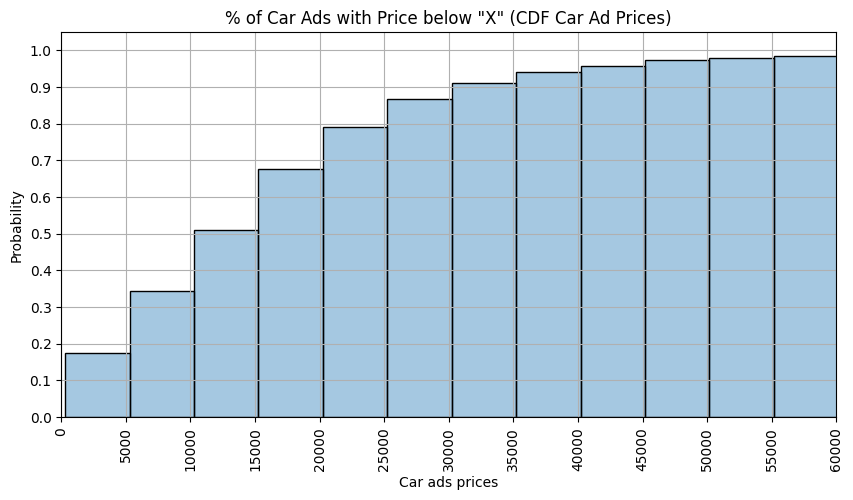

In [16]:
plt.figure(figsize=(10,5))
plt.grid()
sns.histplot(df['price'], binwidth=5_000, stat='probability', cumulative=True, alpha=0.4)
plt.xlim(0,60_000)
plt.xticks(np.arange(0,65_000, 5_000), rotation=90)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('Car ads prices')
plt.title('% of Car Ads with Price below "X" (CDF Car Ad Prices)');

In [17]:
# 1 out of 6 car ads are under 5,000 EUR
# 1 out of 3 car ads are under 10,000 EUR
# Half of the car ads are up to 15,000 EUR
# 2/3 of the car ads are up to 20,000 EUR
# 90% of the car ads are up to 35,000 EUR
# 95% of the car ads are up to 45,000 EUR

## Km analysis

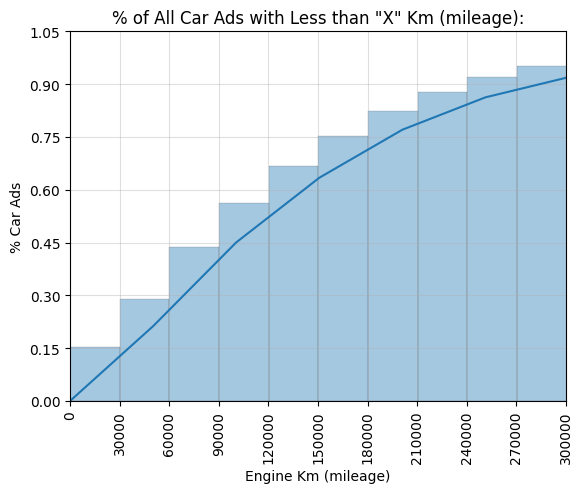

In [18]:
sns.histplot(data=df['km'], kde=True, stat='probability', cumulative=True, binwidth=30_000, alpha=0.4)
plt.title('% of All Car Ads with Less than "X" Km (mileage):')
plt.xlabel('Engine Km (mileage)')
plt.ylabel('% Car Ads')
plt.xlim(0,300_000)
plt.grid(alpha=0.4)
plt.yticks(np.arange(0.00,1.1,0.15))
plt.xticks(np.arange(0,325_000,30_000), rotation=90);

In [19]:
# Create a dictionary to store the quantile expressions for each quantile
quantile_exprs = [pl.col('km').quantile(q).alias(f'quantile_{q:.2f}') for q in quantiles]

# Use the select method with the list of quantile expressions
df_quantiles = df.select(quantile_exprs)

In [20]:
df_quantiles

quantile_0.00,quantile_0.03,quantile_0.05,quantile_0.10,quantile_0.15,quantile_0.20,quantile_0.25,quantile_0.30,quantile_0.35,quantile_0.40,quantile_0.45,quantile_0.50,quantile_0.55,quantile_0.60,quantile_0.65,quantile_0.70,quantile_0.75,quantile_0.80,quantile_0.85,quantile_0.90,quantile_0.95,quantile_0.97,quantile_0.98,quantile_0.99,quantile_1.00
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.0,"1,000.0","7,000.0","17,857.0","29,300.0","41,359.0","52,043.0","62,447.0","72,500.0","82,845.0","93,564.0","104,950.0","118,000.0","130,717.0","146,000.0","162,000.0","180,000.0","200,000.0","225,000.0","256,000.0","300,000.0","334,000.0","360,000.0","400,000.0",9.999999e6


In [21]:
# 25% of car ads have mileage below 50,000 km
# Almost 25% have mileage between 50,000 and 100,000 km
# 25% have mileage between 100,000 and 180,000 km
# 25% have mileage above 180,000 km

In [22]:
df.select(
    (pl.col('km') > 500_000).alias('over_500K_Km')
)['over_500K_Km'].value_counts(normalize=True)

over_500K_Km,proportion
bool,f64
false,0.997221
true,0.002779


In [23]:
df.select(
    (pl.col('km') > 400_000).alias('over_400K_Km')
)['over_400K_Km'].value_counts()

over_400K_Km,count
bool,u32
false,"182,096"
true,"1,794"


In [24]:
# We'll simply filter out models with over 500,000 Km as they're clearly outliers and don't represent even 0.3% of the total data
df = (
    df
    .filter(pl.col('km') < 500_000)
)

## Age (Years) of car analysis

In [25]:
df.shape

(183287, 23)

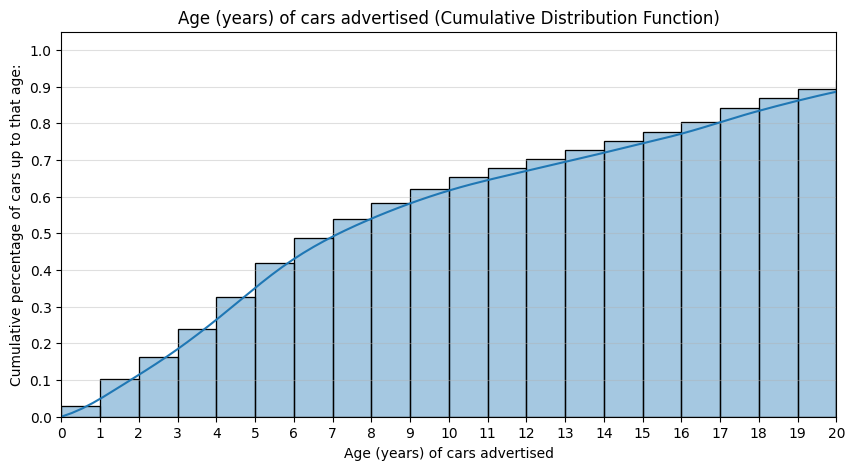

In [26]:
plt.figure(figsize=(10,5))
sns.histplot(df['age_years'], binwidth=1, cumulative=True, kde=True, alpha=0.4, stat='probability')
plt.yticks(np.arange(0.00,1.1,0.1))
plt.xlim(0,20)
plt.grid(axis='y', alpha=0.4)
plt.xticks(np.arange(0,21,1))
plt.title('Age (years) of cars advertised (Cumulative Distribution Function)')
plt.xlabel('Age (years) of cars advertised')
plt.ylabel('Cumulative percentage of cars up to that age:');

In [27]:
# 25% of cars are up to 4 years old
# 50% of cars are up to 7 years old
# 75% of cars are up to 15 years old 

In [28]:
(
    df
    .plot
    .box(y='age_years')
)

:BoxWhisker   (age_years)

In [29]:
# Create a dictionary to store the quantile expressions for each quantile
quantile_exprs = [pl.col('age_years').quantile(q).alias(f'quantile_{q:.2f}') for q in quantiles]

# Use the select method with the list of quantile expressions
df_quantiles = df.select(quantile_exprs)

In [30]:
df_quantiles

quantile_0.00,quantile_0.03,quantile_0.05,quantile_0.10,quantile_0.15,quantile_0.20,quantile_0.25,quantile_0.30,quantile_0.35,quantile_0.40,quantile_0.45,quantile_0.50,quantile_0.55,quantile_0.60,quantile_0.65,quantile_0.70,quantile_0.75,quantile_0.80,quantile_0.85,quantile_0.90,quantile_0.95,quantile_0.97,quantile_0.98,quantile_0.99,quantile_1.00
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,1.0,1.0,1.0,2.0,3.0,4.0,4.0,5.0,5.0,6.0,7.0,8.0,9.0,10.0,12.0,14.0,16.0,18.0,20.0,23.0,25.0,27.0,32.0,54.0


In [31]:
# We´ll opt to filter very old cars, over 40 years old (we're filtering around 500 cars out of 180,000):
df = (
    df
    .filter(pl.col("age_years") <= 40)
)

## Brand and model analysis

In [32]:
brand_rank_ads_df = (
    df['brand'].value_counts(sort=True).with_row_index(name='rank',offset=1)
    .with_columns(
        (100 * pl.col("count") / pl.col('count').sum()).round(2).alias("perc_ads"))
        )

In [33]:
# Top 10 car brands by number of ads
brand_rank_ads_df.head(10)

rank,brand,count,perc_ads
u32,str,u32,f64
1,"""volkswagen""","16,732",9.15
2,"""mercedes-benz""","15,224",8.33
3,"""bmw""","14,662",8.02
4,"""peugeot""","13,635",7.46
5,"""audi""","12,310",6.73
6,"""renault""","10,255",5.61
7,"""citroen""","10,124",5.54
8,"""seat""","9,862",5.39
9,"""ford""","9,221",5.04


In [34]:
model_rank_ads_df = (
    df.group_by("brand","model")
    .agg(
        pl.len().alias("count_ads")
    )
    .sort(by="count_ads", descending=True)
    .with_row_index(name="rank", offset=1)
    .with_columns(
        (100*pl.col("count_ads") / pl.col('count_ads').sum()).round(2).alias("perc_ads")
    )
)

In [35]:
# The 30 car models with more ads, represent over a third of the total ads
round(model_rank_ads_df.head(30)['perc_ads'].sum(),2)

35.57

In [36]:
# There are around 1200 car models in total.
# The top 10 models (by number of ads) represents 1/6 of all car ads
# The top 20 models (by number of ads) represents 25% of all car ads
# The top 60 models (by number of ads) represent 50% of all car ads 
# The top 150 models (by number of ads) represent 75% of all car ads
model_rank_ads_df = model_rank_ads_df.with_columns(pl.col('perc_ads').cum_sum().alias('perc_ads_cum'))
model_rank_ads_df.head(10)

rank,brand,model,count_ads,perc_ads,perc_ads_cum
u32,str,str,u32,f64,f64
1,"""volkswagen""","""golf""","5,251",2.87,2.87
2,"""bmw""","""serie 3""","3,536",1.93,4.8
3,"""seat""","""leon""","3,330",1.82,6.62
4,"""seat""","""ibiza""","2,813",1.54,8.16
5,"""audi""","""a3""","2,650",1.45,9.61
6,"""mercedes-benz""","""clase a""","2,619",1.43,11.04
7,"""ford""","""focus""","2,501",1.37,12.41
8,"""mercedes-benz""","""clase c""","2,494",1.36,13.77
9,"""bmw""","""serie 1""","2,432",1.33,15.1


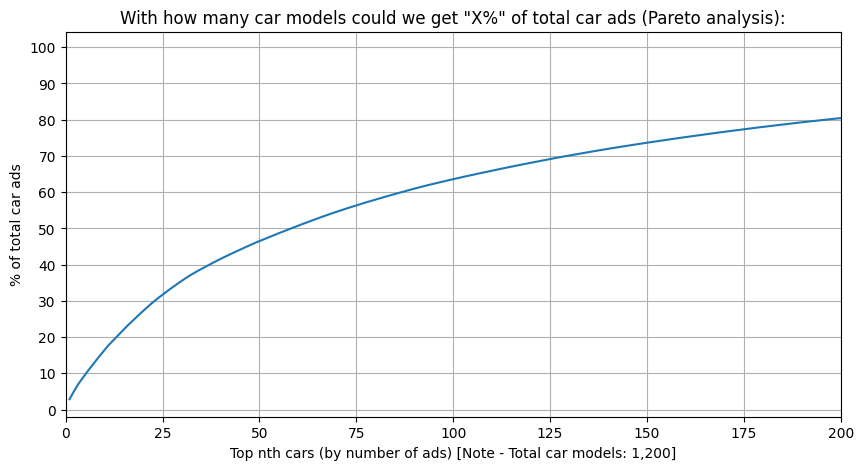

In [37]:
plt.figure(figsize=(10,5))
sns.lineplot(x=model_rank_ads_df['rank'], y=model_rank_ads_df['perc_ads_cum'])
plt.title('With how many car models could we get "X%" of total car ads (Pareto analysis):')
plt.xlabel('Top nth cars (by number of ads) [Note - Total car models: 1,200]')
plt.ylabel('% of total car ads')
plt.xlim(0,200)
plt.yticks(np.arange(0,110, 10))
plt.xticks(np.arange(0,225, 25))
plt.grid()

In [38]:
# Create a dictionary to store the quantile expressions for each quantile
quantile_exprs = [pl.col('count_ads').quantile(q).alias(f'quantile_{q:.2f}') for q in quantiles]

# Use the select method with the list of quantile expressions
df_quantiles = model_rank_ads_df.select(quantile_exprs)

In [39]:
df_quantiles

quantile_0.00,quantile_0.03,quantile_0.05,quantile_0.10,quantile_0.15,quantile_0.20,quantile_0.25,quantile_0.30,quantile_0.35,quantile_0.40,quantile_0.45,quantile_0.50,quantile_0.55,quantile_0.60,quantile_0.65,quantile_0.70,quantile_0.75,quantile_0.80,quantile_0.85,quantile_0.90,quantile_0.95,quantile_0.97,quantile_0.98,quantile_0.99,quantile_1.00
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.0,1.0,1.0,2.0,3.0,4.0,5.0,7.0,10.0,13.0,17.0,22.0,31.0,42.0,58.0,76.0,106.0,164.0,237.0,385.0,744.0,"1,035.0","1,486.0","2,016.0","5,251.0"


In [40]:
#16% of car models, represent 80% of total car ads

In [41]:
# 930 out of 1200 car models have 5 or more ads. The more ads for a model, the easier (in principle) will be to estimate a "market price" for a car model
(
    model_rank_ads_df
    .filter(pl.col('count_ads') >= 5)
).shape[0]

930

In [42]:
model_price_variability_df = (
    df
    .group_by('brand','model')
    .agg(
        pl.col('price').mean().round(1).alias('price_mean'),
        pl.col('price').std().round(1).alias('price_std').fill_null(0),
        (pl.col('price').std().fill_null(0) / pl.col('price').mean()).round(2).alias('price_coeff_var')
    )
    .sort(by='price_coeff_var', descending=True)
)

In [43]:
model_price_variability_df.head(10)

brand,model,price_mean,price_std,price_coeff_var
str,str,f64,f64,f64
"""asia motors""","""rocsta""","9,050.0","13,832.1",1.53
"""ssangyong""","""musso""","6,214.4","8,410.1",1.35
"""isuzu""","""pick up""","15,000.0","19,091.9",1.27
"""fiat""","""uno""","10,208.3","12,552.0",1.23
"""piaggio""","""quargo""","2,433.3","2,926.3",1.2
"""audi""","""a4 allroad""","5,150.0","6,151.8",1.19
"""peugeot""","""309""","6,850.0","7,990.3",1.17
"""ford""","""sierra""","6,320.8","7,332.5",1.16
"""renault""","""r5""","6,113.3","6,994.4",1.14


In [44]:
model_rank_ads_df = model_rank_ads_df.join(model_price_variability_df, left_on=['brand', 'model'], right_on=['brand','model'], how='left')

In [45]:
model_rank_ads_df = model_rank_ads_df.with_columns(pl.col('count_ads').cast(pl.Int32))

In [46]:
model_rank_ads_df.head()

rank,brand,model,count_ads,perc_ads,perc_ads_cum,price_mean,price_std,price_coeff_var
u32,str,str,i32,f64,f64,f64,f64,f64
1,"""volkswagen""","""golf""","5,251",2.87,2.87,"14,830.4","9,889.0",0.67
2,"""bmw""","""serie 3""","3,536",1.93,4.8,"13,959.3","10,601.1",0.76
3,"""seat""","""leon""","3,330",1.82,6.62,"13,217.0","7,634.6",0.58
4,"""seat""","""ibiza""","2,813",1.54,8.16,"8,489.3","5,448.0",0.64
5,"""audi""","""a3""","2,650",1.45,9.61,"17,218.5","11,982.2",0.7


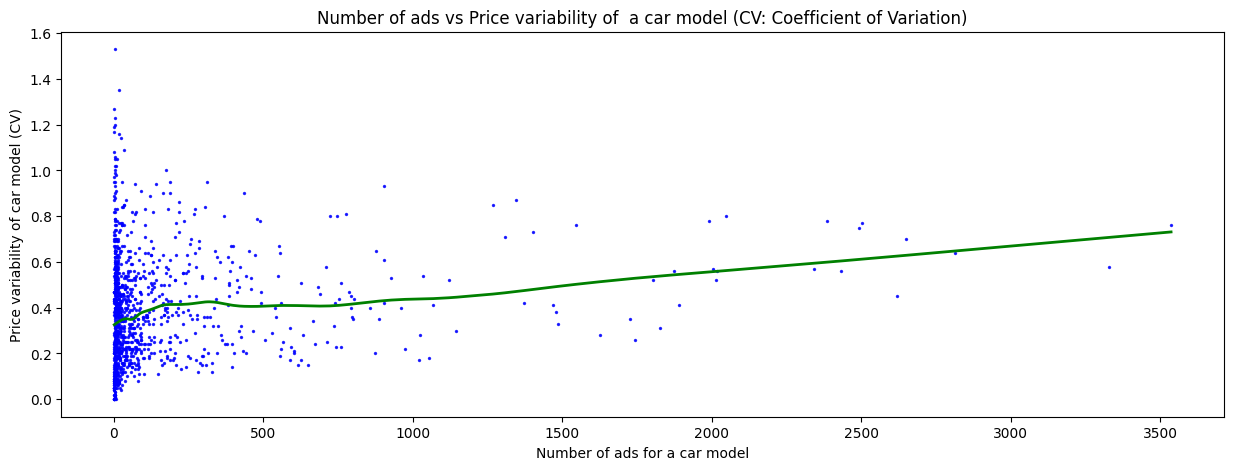

In [47]:
# We cannot conclude that a model with more ads has lower price variability
# At the same time, models with few ads have a wider range of price variability.
# Therefore, it seems that price variability is more robust for models that have more car ads

plt.figure(figsize=(15,5))
sns.regplot(data= model_rank_ads_df.filter(pl.col('count_ads').is_between(2,4_000)),
            x='count_ads',
            y='price_coeff_var',
            lowess=True,
            scatter_kws={'s': 2, 'color':'blue'},
            line_kws={'color': 'green', 'lw':2},
)

plt.title('Number of ads vs Price variability of  a car model (CV: Coefficient of Variation)')
plt.xlabel('Number of ads for a car model')
plt.ylabel('Price variability of car model (CV)');

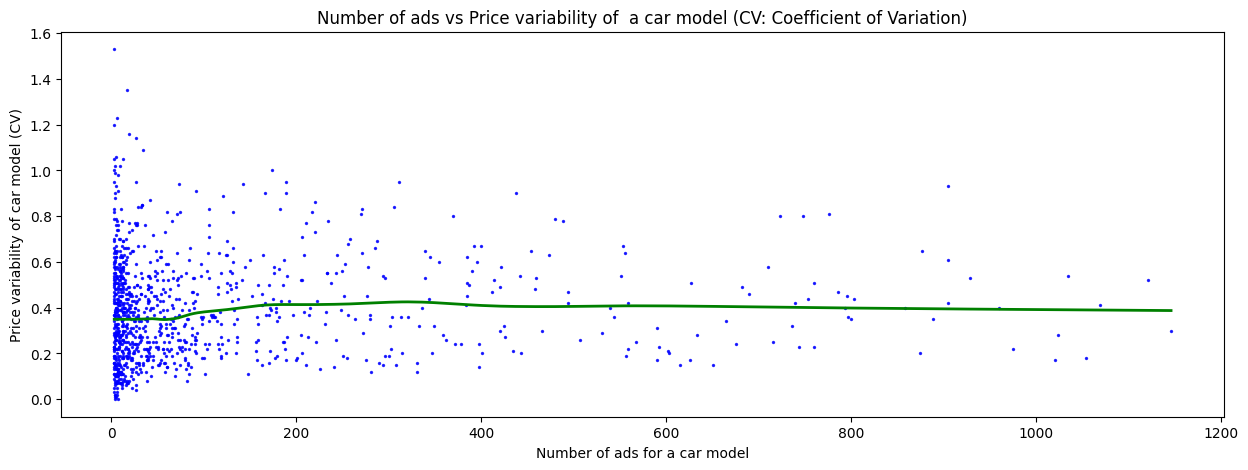

In [48]:

plt.figure(figsize=(15,5))
sns.regplot(data= model_rank_ads_df.filter(pl.col('count_ads').is_between(3,1_200)),
            x='count_ads',
            y='price_coeff_var',
            lowess=True,
            scatter_kws={'s': 2, 'color':'blue'},
            line_kws={'color': 'green', 'lw':2},
)

plt.title('Number of ads vs Price variability of  a car model (CV: Coefficient of Variation)')
plt.xlabel('Number of ads for a car model')
plt.ylabel('Price variability of car model (CV)');

In [49]:
# 80% of car models have a number of ads between 3 and 1000 (We just discarded the low and top 10%). 
# We can see that the mean price variability remains flat (horizontal line) for the whole range
# We can conclude that most car models (80% of all car models) have a price variability of around 39%
print('average model price variability (%):')
model_rank_ads_df.filter(pl.col('count_ads').is_between(3,1_000)).select(100 * pl.col('price_coeff_var').mean())

average model price variability (%):


literal
f64
39.0


## Ad days analysis:

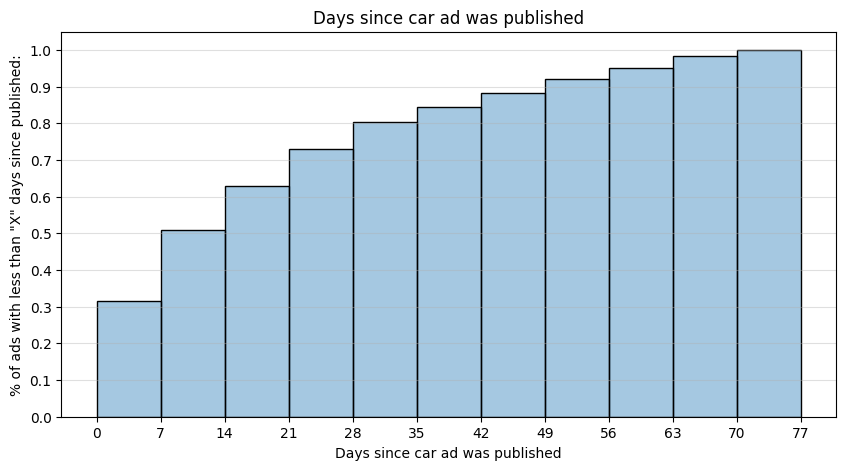

In [50]:
plt.figure(figsize=(10,5))
plt.grid(axis='y', alpha=0.4)

# Define the bin edges to ensure they align with desired steps
bin_edges = np.arange(0, df['ad_days_published'].max() + 7, 7)

# Plot the histogram with explicit bin edges
sns.histplot(df['ad_days_published'], bins=bin_edges, stat='probability', cumulative=True, alpha=0.4)

# Set the x-ticks to align exactly with the bin edges
plt.xticks(ticks=bin_edges)

plt.yticks(np.arange(0,1.1,0.1))

plt.title('Days since car ad was published')
plt.xlabel('Days since car ad was published')
plt.ylabel('% of ads with less than "X" days since published:');

In [51]:
# 30% of ads available were published in the last week
# 50% of ads available were published in the last two weeks
# 75% of ads available were published in the last month

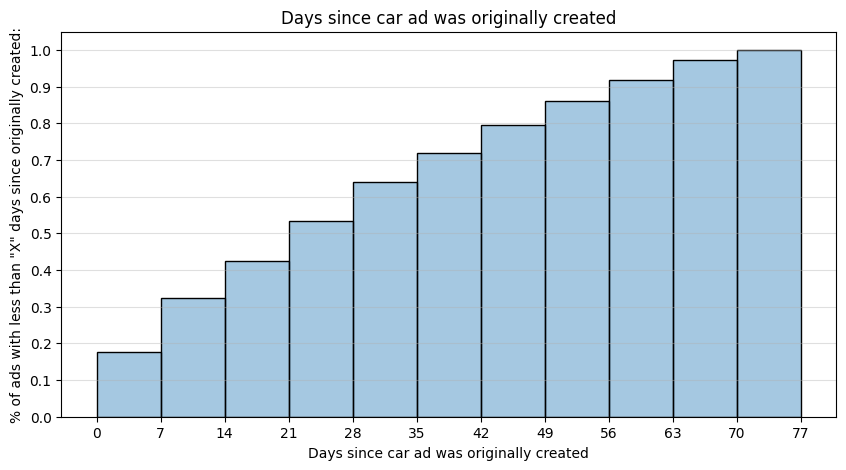

In [52]:
plt.figure(figsize=(10,5))
plt.grid(axis='y', alpha=0.4)

# Define the bin edges to ensure they align with desired steps
bin_edges = np.arange(0, df['ad_days_creation'].max() + 7, 7)

# Plot the histogram with explicit bin edges
sns.histplot(df['ad_days_creation'], bins=bin_edges, stat='probability', cumulative=True, alpha=0.4)

# Set the x-ticks to align exactly with the bin edges
plt.xticks(ticks=bin_edges)

plt.yticks(np.arange(0,1.1,0.1))

plt.title('Days since car ad was originally created')
plt.xlabel('Days since car ad was originally created')
plt.ylabel('% of ads with less than "X" days since originally created:');

+ 1 in 6 ads was created last week  
+ 1 in 3 ads was created in the last two weeks  
+ Over Half ads were created last month  
+ Almost 75% of ads were created in the last month and a half  

Note:  
+ I believe creation_date is more representative than published date of how long a car has been for sale.  
+ published_date could be adjusted so the ad could look like new.  
+ Further analysis would be needed to confirm this hypothesis (outside the scope of the current project).  

## Location (Spanish Province) Analysis:

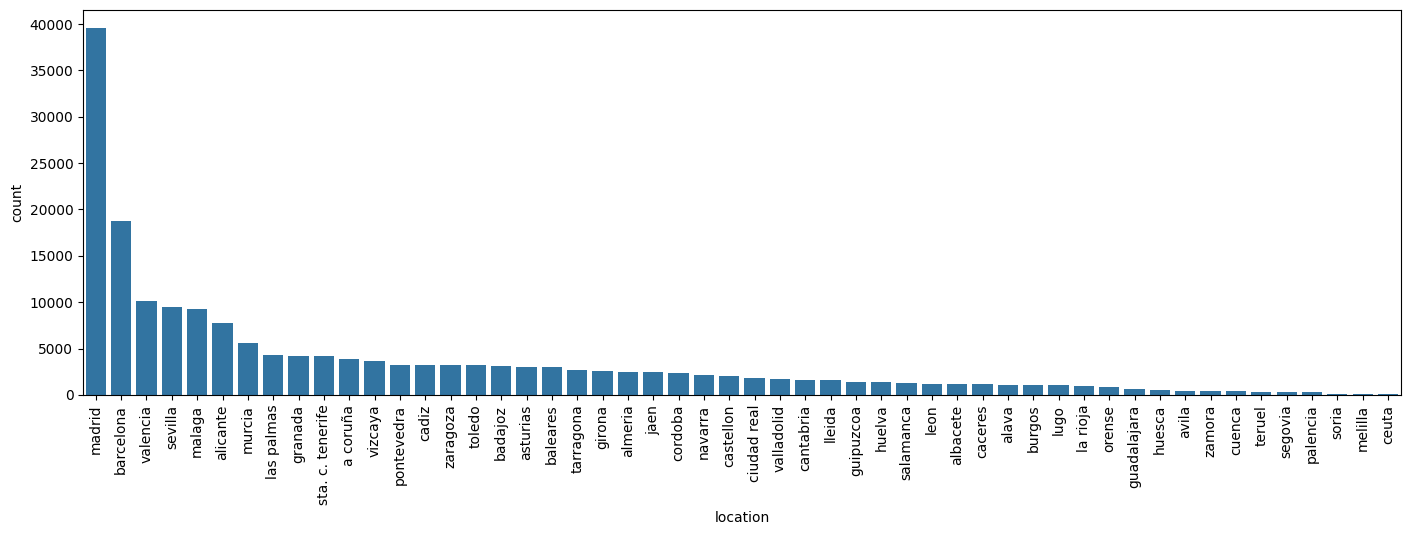

In [53]:
plt.figure(figsize=(17,5))
sns.barplot(data=df['location'].value_counts(sort=True), x='location', y='count')
plt.xticks(rotation=90);

We can observe that 50% of the ads are coming from the top 5 provinces. Madrid represents almost 1 in 4 ads.  

The other 50% of the ads are distributed quite evenly among the other 47 provinces.

In [54]:
df['location'].value_counts(sort=True, normalize=True).select(
    pl.col('location'),
    pl.col('proportion').round(2),
    pl.col('proportion').cum_sum().round(2).alias('cum_perc')
).with_row_index(name='rank', offset=1).head(10)

rank,location,proportion,cum_perc
u32,str,f64,f64
1,"""madrid""",0.22,0.22
2,"""barcelona""",0.1,0.32
3,"""valencia""",0.06,0.37
4,"""sevilla""",0.05,0.43
5,"""malaga""",0.05,0.48
6,"""alicante""",0.04,0.52
7,"""murcia""",0.03,0.55
8,"""las palmas""",0.02,0.57
9,"""granada""",0.02,0.6


## What is the 'median' car advertised:
A car that costs 15K (EUR), has around 100K Km (mileage), and is 7 years old.

In [55]:
df.select(pl.col(pl.Int32).median().cast(int)).drop('bodyTypeId')

price,km,year,age_years,ad_days_creation,ad_days_published,cubic_capacity
i64,i64,i64,i64,i64,i64,i64
"14,995","104,350","2,017",7,26,13,"1,598"


In [56]:
# From the 180K ads published, there are 11K that have more favorable values than the median price, km, age car:
(df
 .filter(
     (pl.col('price') < 15_000) &
     (pl.col('km') < 100_000) &
     (pl.col('age_years') < 7)
     )
).shape

(11077, 23)

In [ ]:
# Conversion factors
kw_to_cv = 1.3596
cv_to_kw = 1 / kw_to_cv

# Extract KW and CV using regex, and cast to Int32
df = df.with_columns([
    # Extract kw from the title
    pl.col("title").str.extract(r"(\d+)\s?kw", 1).cast(pl.Int32).alias("kw"),
    
    # Extract cv from the title
    pl.col("title").str.extract(r"(\d+)\s?cv", 1).cast(pl.Int32).alias("cv")
])

# Fill missing KW using the conversion from CV
df = df.with_columns(
    pl.when(pl.col("kw").is_null() & pl.col("cv").is_not_null())
    .then((pl.col("cv") * cv_to_kw).cast(pl.Int32))  # Cast result to Int32
    .otherwise(pl.col("kw"))
    .alias("kw")
)

# Fill missing CV using the conversion from KW
df = df.with_columns(
    pl.when(pl.col("cv").is_null() & pl.col("kw").is_not_null())
    .then((pl.col("kw") * kw_to_cv).cast(pl.Int32))  # Cast result to Int32
    .otherwise(pl.col("cv"))
    .alias("cv")
)

## Final adjustments and file saving for modeling

In [57]:
print(df.columns)

['price', 'brand', 'model', 'is_automatic', 'km', 'fuel', 'year', 'age_years', 'is_seller_pro', 'is_certified', 'offer_type', 'location', 'ad_days_creation', 'ad_days_published', 'bodyTypeId', 'cubic_capacity', 'title', 'url', 'body_type', 'price_outlier_low', 'price_median', 'price_outlier_up', '%_deviation_price_median']


In [20]:
# We filter out the columns created for price analysis as outlier filtering is already done
df = (
    df
    .select(
        ['price', 'brand', 'model', 'is_automatic', 'km', 'fuel', 'year', 'age_years', 'cv', 'kw','body_type', 'cubic_capacity',
        'is_seller_pro', 'is_certified', 'offer_type', 'location', 'ad_days_creation', 'ad_days_published',  'title', 'url']
    )
)

In [29]:
df.write_parquet('car_ads_model.parquet')

In [30]:
df = pl.read_parquet('car_ads_model.parquet')

In [31]:
df.shape

(182826, 20)